### Notebook for the first part of the course, that is to get to the point where the matrix multiplication capability has been generated

This is for the course in late 2022

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Get Data 

In [3]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_to_data = Path('/Users/johnrichmond/datasets') / Path('data')
path_to_data.mkdir(exist_ok=True)
path_gz = path_to_data / 'mnist.pkg.gz'

https://docs.python.org/3/library/urllib.request.html

Will use urllib to load the mnist library

In [4]:
if not path_gz.exists():  urlretrieve(MNIST_URL, path_gz)

In [5]:
path_to_data

PosixPath('/Users/johnrichmond/datasets/data')

In [5]:
!ls /Unsers/johnrichmond/datasets/data

ls: /Unsers/johnrichmond/datasets/data: No such file or directory


In [6]:
with gzip.open(path_gz) as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin')

In [7]:
lst = list(x_train[0])
vals = lst[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

Create a function to return chunks of the data using until it is exhausted

In [8]:
def chunks(x, size):
    for i in range(0, len(x), size): yield(x[i:i+size])

In [9]:
list(chunks(vals,5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

Now use the list to put data into the form that it can be plotted

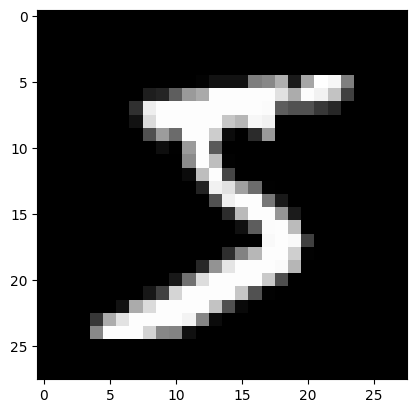

In [10]:
img = list(chunks(lst, 28))
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(img)

Introduction to itertools and islice 
https://docs.python.org/3/library/itertools.html

In [11]:
from itertools import islice

In [15]:
it = iter(vals)

In [16]:
list(islice(it,5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [17]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [18]:
it = iter(lst)
img = list(iter(lambda: list(islice(it, 28)), []))

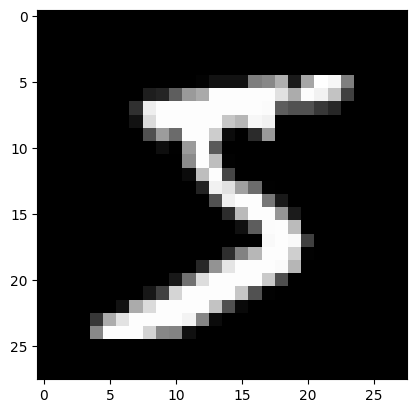

In [19]:
plt.imshow(img)

### Tensors and matricies 

In [20]:
img[10][11]

0.6015625

In [21]:
class Matrix():
    def __init__(self, xs):
        self.xs = xs
    
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [22]:
mat = Matrix(img)

In [23]:
mat[10,11]

0.6015625

In [24]:
import torch
from torch import tensor

In [25]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
y_valid.shape

torch.Size([10000])

In [26]:
x_train.shape

torch.Size([50000, 784])

In [27]:
x_train = x_train.reshape([-1, 28, 28])

In [28]:
x_train.shape

torch.Size([50000, 28, 28])

### Random Numbers

In [29]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [30]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [31]:
def my_rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [32]:
my_rand(), my_rand()

(0.7645251082582081, 0.7920889799553945)

In [33]:
# os.fork() returns 0, hence false for the child
if os.fork(): print(f'in parent {my_rand()}')
else:
    print(f'in child {my_rand()}')

in parent 0.06912886811267205
in child 0.06912886811267205


In [34]:
if os.fork(): print(f'in parent {torch.rand(1)}')
else:
    print(f'in child {torch.rand(1)}')

in parent tensor([0.8320])
in child tensor([0.8320])


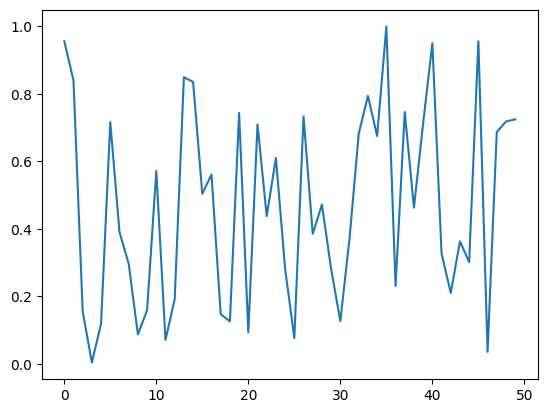

In [35]:
plt.plot([my_rand() for _ in range(50)])

(array([ 959.,  972., 1036., 1019., 1037.,  971.,  997., 1000., 1036.,
         973.]),
 array([6.60514437e-06, 1.00005135e-01, 2.00003666e-01, 3.00002196e-01,
        4.00000726e-01, 4.99999256e-01, 5.99997787e-01, 6.99996317e-01,
        7.99994847e-01, 8.99993378e-01, 9.99991908e-01]),
 <BarContainer object of 10 artists>)

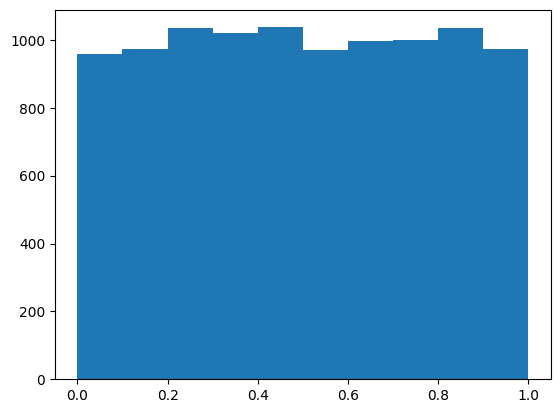

In [36]:
plt.hist([my_rand() for _ in range(10000)])

In [37]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 18.41 times longer than the fastest. This could mean that an intermediate result is being cached.
202 µs ± 310 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit -n 10 chunks([my_rand() for _ in range(7840)], 10)

5.88 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


clearly pytorch is very optimised

### Matrix Multiiplication 

In [39]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [40]:
m1 = x_valid[:5]
m2 = weights

In [41]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [42]:
def my_matmul(m1,  m2):
    ld = m1.shape[-1]
    nrow = m1.shape[0]
    ncol = m2.shape[-1]
    res = torch.zeros(nrow, ncol)
    for row in range(nrow):
        for col in range(ncol):
            for elem in range(ld):
                res[row, col] += m1[row, elem] * m2[elem, col]
    return res

In [43]:
res = my_matmul(m1, m2)
res[2:12, 3:15]

tensor([[ -9.8059,   6.2303,   1.4751,  -5.2005,   0.4335,   0.7038,   7.6098],
        [-13.5486,  16.3671,   1.8007,  -3.9269,  -5.1790, -13.6882,  -4.0373],
        [ -4.8082,   4.8965,   1.0627,  -4.4259,   6.7147,   0.7432,   7.1297]])

In [44]:
test_torch = torch.matmul(m1, m2)

In [45]:
test_torch[2:12, 3:15]

tensor([[ -9.8059,   6.2303,   1.4751,  -5.2005,   0.4335,   0.7038,   7.6098],
        [-13.5486,  16.3671,   1.8007,  -3.9269,  -5.1790, -13.6882,  -4.0373],
        [ -4.8082,   4.8965,   1.0627,  -4.4259,   6.7147,   0.7432,   7.1297]])

In [46]:
%time _=my_matmul(m1, m2)

CPU times: user 754 ms, sys: 8.15 ms, total: 762 ms
Wall time: 767 ms


### Numba 

In [47]:
from numba import njit

In [48]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [49]:
def my_numba_matmul(m1,  m2):
    ld = m1.shape[-1]
    nrow = m1.shape[0]
    ncol = m2.shape[-1]
    res = torch.zeros(nrow, ncol)
    for row in range(nrow):
        for col in range(ncol):
            res[row, col] = dot(m1[row, :], m2[:, col])
    return res

In [50]:
m1a,m2a = m1.numpy(),m2.numpy()

In [51]:
%time _=my_numba_matmul(m1a, m2a)

CPU times: user 618 ms, sys: 186 ms, total: 803 ms
Wall time: 815 ms


In [52]:
from fastcore.test import *

In [53]:
test_close(my_numba_matmul(m1a, m2a), res.numpy())

### Elementwise Ops

In [54]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [55]:
m = torch.arange(1, 10).float().reshape(-1,3)

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [56]:
es = (m*m).sum().sqrt()
es

tensor(16.8819)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcast vector to matrix

In [57]:
c = tensor([10.,20,30])

In [58]:
c.shape, m.shape

(torch.Size([3]), torch.Size([3, 3]))

In [59]:
c+m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In this case c has an additinal dimension added and the row is duplicated across each new row.  This effect can be see using the expand_as method

In [60]:
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [61]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 3]

So although it shows as a 3x3 matrix it is stored as a vector.  This makes use of the same stride concept as is used in convolutions, it t has a stride of 1

In [62]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

There are several ways to expand dimensions in torch.  The most common are unsqueeze or to use none to create a new dimension as follows:

In [63]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [64]:
c.unsqueeze(1), c[:, None], c[...,None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [65]:
c[None], c[None].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

### Broadcasting Rules

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

In [66]:
c*c

tensor([100., 400., 900.])

In [67]:
c.shape, c[None].shape

(torch.Size([3]), torch.Size([1, 3]))

In [68]:
c*c[None], (c*c[None]).shape

(tensor([[100., 400., 900.]]), torch.Size([1, 3]))

In this case the first dims are the same and the scond dim only exists in one, where it is one, hence the first c has a dim added and made equal to one prior to multiplication

In [69]:
c[None,:].shape,  c[:,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [70]:
c[None,:].expand_as(m),  c[:,None].expand_as(m)

(tensor([[10., 20., 30.],
         [10., 20., 30.],
         [10., 20., 30.]]),
 tensor([[10., 10., 10.],
         [20., 20., 20.],
         [30., 30., 30.]]))

In this case both arrays are expanded in the dim having a unit entry to give the above.  Note that we have expanded in different dimensions


In [71]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

###  Matmul with broadcasting

In [72]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

Multiple pixel values for an image and the weights (m2).  at present then can't be multiplied since the first dimensions don't match and neither is 1

In [73]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros([ar, bc])
    for row in range(ar):
        # note that in the line below adding the None on the right of a means that the rows become columns 
        # and the columns can then be broadcast across the columns of b giving a matrix that is shape ac, bc
        # which can then be summed on the 0 dim to provide the values for the ith row of c
        c[row] = (a[row, :, None] * b).sum(0)
    return c

In [74]:
test_close(res,matmul(m1, m2))

In [75]:
%timeit -n 10 _=matmul(m1, m2)

343 µs ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
x_train = x_train.reshape(50000, -1)

In [77]:
# Apply to the whole matrix
tr = matmul(x_train, weights)

In [78]:
%time _=matmul(x_train, weights)

CPU times: user 1.35 s, sys: 13.1 ms, total: 1.36 s
Wall time: 1.37 s


### Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [79]:
def matmul(a,b):
    return torch.einsum('ij,jk->ik', a, b)

In [80]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [81]:
As = torch.randn(3,2,5)
Bs = torch.randn(3,5,4)
torch.einsum('bij,bjk->bik', As, Bs)

tensor([[[ 0.2511, -5.5621,  0.0876, -3.1953],
         [ 0.9445, -2.2308,  0.9471, -1.6744]],

        [[ 0.2117, -0.3673,  0.3529, -0.6663],
         [ 0.3634, -0.0850, -1.1573,  2.2852]],

        [[ 0.5646,  0.7506,  0.3744, -0.8820],
         [-2.0568, -2.2881, -3.2916, -0.9757]]])

In [82]:
As = torch.randn(2,5)
Bs = torch.randn(5,4)
torch.einsum('ij,jk->ik', As, Bs)

tensor([[ 0.6352, -5.0310, -2.4586, -2.8751],
        [ 1.9462, -6.0367, -2.7016, -1.8206]])

In [83]:
test_close(res,matmul(m1, m2), eps=1.e-3)

In [87]:
%timeit -n 5 _=matmul(m1, m2)

The slowest run took 6.02 times longer than the fastest. This could mean that an intermediate result is being cached.
74.9 µs ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


### Pytorch Op

In [84]:
test_close(tr, x_train@weights, eps=1e-3)

In [88]:
%timeit -n 5 _=x_train@weights

28.5 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


### Cuda

In [102]:
a = torch.rand(5,8)
b = torch.rand(8,10)

In [103]:
# Define a function that will perform multiplication for specified row column pairs
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [104]:
# So for just the 0,0 point we have
(ar, ac), (br, bc) = a.shape, b.shape
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[3.0853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

In [106]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [107]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[  3.0853,  -6.6982,  -3.5543,  -3.7494,  -1.9021, -10.1380,   6.9035,
           5.0624, -11.3436,  -2.3460],
        [  2.0391,   2.2280,  -7.9930, -14.0625,  14.0156,   2.5221,  16.7039,
          -7.7319,  12.0608,  -7.5355],
        [ -0.6708,   1.1113, -12.3503,  -9.8059,   6.2303,   1.4751,  -5.2005,
           0.4335,   0.7038,   7.6098],
        [-10.1180,  -6.3266,  -7.3202, -13.5486,  16.3671,   1.8007,  -3.9269,
          -5.1790, -13.6882,  -4.0373],
        [ -2.3448,  -1.8089,  -5.9940,  -4.8082,   4.8965,   1.0627,  -4.4259,
           6.7147,   0.7432,   7.1297]])

In [108]:
# Now import numba so that we can start to use parallel processing on the GPU
from numba import cuda

In [ ]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp
    cuda.syncthreads()

In [ ]:
r = torch.zeros(x_train.shape[0], weights.shape[1])
m1g,m2g,rg = cuda.to_device(x_train),cuda.to_device(weights),cuda.to_device(r)

In [111]:
r.shape

torch.Size([50000, 10])

In [ ]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1.03)

In [ ]:
%%timeit -n 1
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

In [ ]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [ ]:
%timeit -n 1 r==(m1c@m2c).cpu()